<a href="https://colab.research.google.com/github/kyrcha/deep-learning-pipelines/blob/master/combined_cycle_power_plant_data_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combined Cycle Power Plant Data Set

Dataset URL: https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant

For this regression task, given the hourly average ambient variables:

* Temperature (T), 
* Ambient Pressure (AP), 
* Relative Humidity (RH) and 
* Exhaust Vacuum (V) 

the goal is to predict the net hourly electrical energy output (EP) of the plant.

The authors of the dataset have given us 5 random shuffles of the dataset, one in each xlsx sheet. We will be using one of them and make a 60-20-20 split: 60% for training, 20% for validation (used for early stopping) and 20% for testing.

## Data reading

Let's go ahead and read the first random shuffle.


In [0]:
# importing some necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import zipfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [0]:
# downloading the dataset
dataset_path = keras.utils.get_file("CCPP.zip", "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip")
dataset_path

3678208/3674852 [==============================] - 0s 0us/step


'/root/.keras/datasets/CCPP.zip'

In [0]:
# unzipping
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('.')

In [0]:
# reading the first sheet
data = pd.read_excel(open('./CCPP/Folds5x2_pp.xlsx', 'rb'), sheet_name='Sheet1')
# check if data is loaded correctly
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [0]:
# Statistical summary of the dataset
data.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


We see that the variables are in different scales and ranges so some pre-processing is needed.

## Data preprocessing

Neural networks work best with normalized features. So we will extract the min and max from the training set and use those to normalize the values on the training, validation and test sets.

In [0]:
# Check if we have unknown values
data.isna().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

# split predictors and target features
X = data[['AT', 'V', 'AP', 'RH']]
y = data['PE']

# split the data (60% training - 40% rest)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, 
                                                  random_state=42, 
                                                    shuffle = False)
# split validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, 
                                                  random_state=42, 
                                                shuffle = False)


In [0]:
# Check the data sizes
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5740, 4)
(1914, 4)
(1914, 4)


In [0]:
stats = X_train.describe()

def standardization(x):
  return (x - stats.loc['mean']) / stats.loc['std']

def normalization(x):
  return (x - stats.loc['min']) / (stats.loc['max'] - stats.loc['min'])

normed_train_data = normalization(X_train)
normed_val_data = normalization(X_val)
normed_test_data = normalization(X_test)

# Check if normalization was performed correctly
normed_train_data.describe().loc[['min', 'max']]

,AT,V,AP,RH
min,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0


## Model Definition

With around 6000 training samples a good heuristic is to use a neural network with around 600 weights. Another way is to build a bigger network and add regularization. In our case we will use early stopping.



In [0]:
l0 = tf.keras.layers.Dense(units=128, input_shape=(4,), 
                           activation='sigmoid')
l1 = tf.keras.layers.Dense(units=32, activation='relu')
l2 = tf.keras.layers.Dense(units=1, activation='linear')  

optimizer = tf.keras.optimizers.Adam(0.001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = tf.keras.Sequential([l0, l1, l2])
model.compile(optimizer = optimizer, 
              loss='mean_squared_error', 
              metrics = ['mean_absolute_error', 'mean_squared_error'])

W0801 07:35:18.733334 140434851002240 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [0]:
history = model.fit(normed_train_data, y_train, 
                    epochs=200, 
                    validation_data=(normed_val_data, y_val),
                    verbose=0,
                    callbacks=[early_stopping])
print('Finished training')

Finished training


## Learning curve visualization

Let's plot the errors (training and validation).

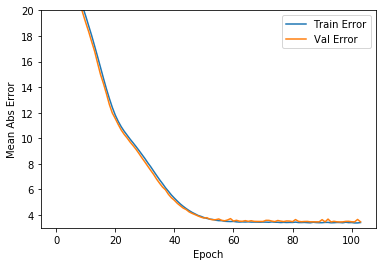

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(hist['epoch'], hist['mean_absolute_error'],
         label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
         label = 'Val Error')
plt.ylim([3,20])
plt.legend()

plt.show()

## Scatter plot of real vs predicted values for the test set

And let's also plot the predicted values vs. the true values of the test set. 

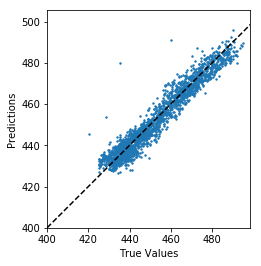

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(y_test.array, test_predictions, s=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([400, plt.xlim()[1]])
plt.ylim([400, plt.ylim()[1]])
_ = plt.plot([400, 500], [400, 500], color='black', linestyle='dashed')
plt.show()

In [0]:
# Check the MAE as well

from sklearn.metrics import mean_absolute_error

print("MAE on test set is: {0:.2f}".format(mean_absolute_error(y_test.array, test_predictions)))

MAE on test set is: 3.44
